# 7장 케라스 모델 활용법

**감사말**: 프랑소와 숄레의 [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff) 3장에 사용된 코드에 대한 설명을 담고 있으며 텐서플로우 2.6 버전에서 작성되었습니다. 소스코드를 공개한 저자에게 감사드립니다.

**tensorflow 버전과 GPU 확인**
- 구글 코랩 설정: '런타임 -> 런타임 유형 변경' 메뉴에서 GPU 지정 후 아래 명령어 실행 결과 확인

    ```
    !nvidia-smi
    ```

- 사용되는 tensorflow 버전 확인

    ```python
    import tensorflow as tf
    tf.__version__
    ```
- tensorflow가 GPU를 사용하는지 여부 확인

    ```python
    tf.config.list_physical_devices('GPU')
    ```

## 주요 내용

- 케라스 모델 구성법
- 케라스 모델 훈련 및 평가
- 사용자 정의 모델 훈련 및 평가

## 7.1 작업 흐름

케라스를 이용하여 매우 단순한 모델부터 매우 복잡한 모델까지 구성 및 훈련이 가능하다. 
케라스의 모델과 층은 모두 각각 `Model` 클래스와 `Layer` 클래스를 상속하기에 
다른 모델에서 사용된 요소들을 재활용하기에도 용이하다.

여기서는 주어진 문제에 따른 케라스 모델 구성법과 훈련법의 다양한 방식을 살펴본다. 

## 7.2 케라스 모델 구성법

케라스를 이용하여 모델을 세 가지 방식으로 구성할 수 있다.

- `Sequential` 모델: 층으로 스택을 쌓아 만든 모델
- 함수형 API 활용: 가장 많이 사용됨.
- 모델 서브클래싱: 모든 것을 사용자가 지정.

가장 간단한 모델부터 아주 복잡한 모델까지 모두 구성할 수 있으며
사용자가 직접 정의한 모델과 레이어도 활용할 수 있다.

<div align="center"><img src="https://drek4537l1klr.cloudfront.net/chollet2/v-7/Figures/progressive_disclosure_of_complexity_models.png" style="width:800px;"></div>

그림 출처: [Deep Learning with Python(Manning MEAP)](https://www.manning.com/books/deep-learning-with-python-second-edition)

### 방법 1: `Sequential` 모델 활용

층으로 스택을 쌓아 만든 모델이며 가장 단순하다.

- 하나의 입력값과 하나의 출력값만 사용 가능
- 층을 지정된 순서대로만 적용 가능

**`Sequential` 클래스**

In [1]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Dense(64, activation="relu"),
    layers.Dense(10, activation="softmax")
])

층의 추가는 `add` 메서드를 이용할 수도 있다.
더해진 순서대로 층이 쌓인다.

In [2]:
model = keras.Sequential()
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dense(10, activation="softmax"))

**`build()` 메서드**

모델 훈련에 사용되는 층별 가중치는 모델이 처음 활용될 때 호출되는
`build()` 메서드에 의해 초기화된다.
이유는 입력값이 들어와야 가중치 텐서의 모양(shape)을 정할 수 있기 때문이다. 
아래 코드 샘플은 [3장](https://codingalzi.github.io/dlp/notebooks/dlp03_introduction_to_keras_and_tf.html)에서 
`SimpleDense`를 선언할 때 사용된 `build()` 메서드를 보여주며,
훈련이 시작되면서 첫 배치 데이터셋이 입력될 때 특성 수를 확인하여
가중치와 편향 텐서를 생성과 동시에 초기화한다.

```python
def build(self, input_shape):
    input_dim = input_shape[-1]   # 입력 샘플의 특성 수
    self.W = self.add_weight(shape=(input_dim, self.units),
                             initializer="random_normal")
    self.b = self.add_weight(shape=(self.units,),
                             initializer="zeros")
```

따라서 지금 당장 가중치를 확인하려 하면 오류가 발생한다.

```python
>>> model.weights

...
ValueError: Weights for model sequential_1 have not yet been created. Weights are created when the Model is first called on inputs or `build()` is called with an `input_shape`.
```

반면에 입력값 대신 `build()` 메서드를 특성 수 정보를 이용하여 직접 호출하면
가중치 텐서가 무작위로 초기화된 형식으로 생성된다.
즉, **모델 빌드**가 완성된다.

- `input_shape` 키워드 인자: `(None, 특성수)`
- `None`은 임의의 크기의 배치도 다룰 수 있다는 것을 의미함.

In [3]:
model.build(input_shape=(None, 3))

모델 빌드가 완성되면 `weights` 속성에 생성된 모델 훈련에 필요한 모든 가중치와 편향이 저장된다.
위 모델에 대해서 층별로 가중치와 편향 텐서 하나씩 총 4 개의 텐서가 생성되나.

In [4]:
len(model.weights)

4

- 1층의 가중치와 편향 텐서

In [5]:
model.weights[0].shape

TensorShape([3, 64])

In [6]:
model.weights[1].shape

TensorShape([64])

- 2층의 가중치와 편향 텐서

In [7]:
model.weights[2].shape

TensorShape([64, 10])

In [8]:
model.weights[3].shape

TensorShape([10])

**`summary()` 메서드**

완성된 모델의 요악한 내용은 확인할 수 있다.

- 모델과 층의 이름
- 층별 파라미터 수
- 파라미터 수

In [9]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 64)                256       
_________________________________________________________________
dense_3 (Dense)              (None, 10)                650       
Total params: 906
Trainable params: 906
Non-trainable params: 0
_________________________________________________________________


**`name` 인자**

모델 또는 층을 지정할 때 생성자 메서등의 `name` 키워드 인자를 이용하여 이름을 지정할 수도 있다.

In [10]:
model = keras.Sequential(name="my_example_model")
model.add(layers.Dense(64, activation="relu", name="my_first_layer"))
model.add(layers.Dense(10, activation="softmax", name="my_last_layer"))

model.build((None, 3))
model.summary()

Model: "my_example_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
my_first_layer (Dense)       (None, 64)                256       
_________________________________________________________________
my_last_layer (Dense)        (None, 10)                650       
Total params: 906
Trainable params: 906
Non-trainable params: 0
_________________________________________________________________


**모델 디버깅**

모델 구성 중간에 구성 과정을 확인하려면 `Input()`함수를 이용하여
**케라스텐서**(`KerasTensor`) 객체를
가장 먼저 모델에 추가한다.
그러면 층을 추가할 때마다 `summary()`를 실행할 수 있다.

- `Input()` 함수: 모델 빌드에 필요한 가중치 텐서 생성에 필요한 정보를 제공하는 `KerasTensor` 객체 생성
- **주의사항**: `shape` 키워드 인자에 사용되는 값은 각 샘플의 특성 수이며,
    앞서 `build()` 메서드의 인자와 다른 형식으로 사용된다.

In [11]:
model = keras.Sequential()
model.add(keras.Input(shape=(3,)))
model.add(layers.Dense(64, activation="relu"))

In [12]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 64)                256       
Total params: 256
Trainable params: 256
Non-trainable params: 0
_________________________________________________________________


In [13]:
model.add(layers.Dense(10, activation="softmax"))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 64)                256       
_________________________________________________________________
dense_5 (Dense)              (None, 10)                650       
Total params: 906
Trainable params: 906
Non-trainable params: 0
_________________________________________________________________


### 방법 2: 함수형 API 활용

다중 입력과 다중 출력을 지원하려면 함수형 API를 활용하여 모델을 구성해야 하며,
가장 많이 사용되는 모델 구성법이다. 
사용법은 간단하다.

```python
Model(inputs, outputs)
```

- `Model` 클래스의 객체 생성
- `inputs` 인자: 하나의 케라스텐서 객체 또는 여러 개의 케라스텐서로 이루어진 리스트
- `outputs` 인자: 하나의 출력층 또는 여러 개의 출력층으로 이루어진 리스트

#### 기본 활용법

앞서 `Sequential` 모델로 구성한 모델을 함수형 API를 이용하여 구성하면 다음과 같다.

In [14]:
inputs = keras.Input(shape=(3,), name="my_input")          # 입력층
features = layers.Dense(64, activation="relu")(inputs)     # 은닉층
outputs = layers.Dense(10, activation="softmax")(features) # 출력층

model = keras.Model(inputs=inputs, outputs=outputs)

사용된 단계들을 하나씩 살펴보자.

- `inputs`

    ```python
    inputs = keras.Input(shape=(3,), name="my_input")
    ```

생성된 값은 `KerasTensor`이다.

In [15]:
type(inputs)

keras.engine.keras_tensor.KerasTensor

케라스텐서(`KerasTensor`)의 모양에서 `None`은 배치 사이즈, 즉 
하나의 훈련 스텝에 사용되는 샘플의 수를 대상으로 하며, 
임의의 크기의 배치를 처리할 수 있다는 의미로 사용된다.

In [16]:
inputs.shape

TensorShape([None, 3])

In [17]:
inputs.dtype

tf.float32

- 은닉층

    ```python
    features = layers.Dense(64, activation="relu")(inputs)
    ```

In [18]:
type(features)

keras.engine.keras_tensor.KerasTensor

In [19]:
features.shape

TensorShape([None, 64])

- `outputs`

    ```python
    outputs = layers.Dense(10, activation="softmax")(features)
    ```

In [20]:
type(outputs)

keras.engine.keras_tensor.KerasTensor

- 모델 빌드

    ```pythoh
    model = keras.Model(inputs=inputs, outputs=outputs)
    ```

In [21]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
my_input (InputLayer)        [(None, 3)]               0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                256       
_________________________________________________________________
dense_7 (Dense)              (None, 10)                650       
Total params: 906
Trainable params: 906
Non-trainable params: 0
_________________________________________________________________


`KerasTensor`의 역할

앞서 보았듯이 케라스텐서는 모델 훈련에 사용되는 텐서들 관련 정보를 제공하는 **가상의 텐서**이다.
빌드되는 모델은 입력 케라스텐서부터 출력 케라스텐서까지 각 층에 저장된 
텐서의 모양 정보를 이용하여 가중치 텐서와 편향 텐서를 생성하고 초기화한다.

#### 다중 입력, 다중 출력 모델 구성법

고객이 사용하는 티켓에 따라 우선순위와 담당부서를 지정하는 모델을 구현하려 하며,
이 모델은 세 개의 입력과 두 개의 출력을 사용한다. 

- 입력
    - `title`: 티켓 종류. 문자열 인코딩. `vocabulary_size` 활용(11장에서 다룸).
    - `text_body`: 티켓 내용. 문자열 인코딩. `vocabulary_size` 활용(11장에서 다룸).
    - `tags`: 사용자에 의한 추가 선택 사항. 원(멀티?)-핫-인코딩 사용.
- 출력
    - `priority`: 티켓의 우선순위. 0에서 1사이의 값. 시그모이드(sigmoid) 값.
    - `department`: 티켓 담당 부서

In [22]:
vocabulary_size = 10000    # 단어량
num_tags = 100             # 태그 수
num_departments = 4        # 부서 수

# 입력층
title = keras.Input(shape=(vocabulary_size,), name="title")
text_body = keras.Input(shape=(vocabulary_size,), name="text_body")
tags = keras.Input(shape=(num_tags,), name="tags")

# 은닉층
features = layers.Concatenate()([title, text_body, tags]) # shape=(None, 10000+10000+100)
features = layers.Dense(64, activation="relu")(features)

# 출력층
priority = layers.Dense(1, activation="sigmoid", name="priority")(features)
department = layers.Dense(
    num_departments, activation="softmax", name="department")(features)

# 모델 빌드
model = keras.Model(inputs=[title, text_body, tags], outputs=[priority, department])

모델 훈련을 위해 적절한 개수의 입력 텐서와 타깃 텐서를 지정해야 한다.
여기서는 훈련 과정을 설명하기 적절한 모양의 입력 텐서 3개와 타깃 텐서 2개를 무작위로 생성해서 사용한다.

In [23]:
import numpy as np

num_samples = 1280

title_data = np.random.randint(0, 2, size=(num_samples, vocabulary_size))
text_body_data = np.random.randint(0, 2, size=(num_samples, vocabulary_size))
tags_data = np.random.randint(0, 2, size=(num_samples, num_tags)) # 멀티-핫-인코딩(?)

priority_data = np.random.random(size=(num_samples, 1))
department_data = np.random.randint(0, 2, size=(num_samples, num_departments))

모델 컴파일 과정에서 타깃에 따라 각각 손실함수와 측정 기준을 지정해야 한다.

- 손실함수(loss)
    - `priority` 대상: `mean_squared_error`
    - `department` 대상: `categorical_crossentropy`
- 평가지표(metrics)
    - `priority` 대상: `["mean_absolute_error"]`
    - `department` 대상: `["accuracy"]`

In [24]:
model.compile(optimizer="adam",
              loss=["mean_squared_error", "categorical_crossentropy"],
              metrics=[["mean_absolute_error"], ["accuracy"]])

모델 훈련은 `fit()` 함수에 세 개의 훈련 텐서로 이루어진 리스트와 
두 개의 타깃 텐서로 이루어진 리스트를 지정한 후에 실행한다. 
여기서는 시험삼아 한 번의 에포크만 사용한다.

- `epochs=1`
- `batch_size=None`: 배치 크기를 지정하지 않으면 32개로 자동 지정됨.
    그래서 스텝수가 40(= 1280/30)이 된다.

In [25]:
model.fit([title_data, text_body_data, tags_data],
          [priority_data, department_data],
          epochs=1)

40/40 [==============================] - 1s 6ms/step - loss: 11.0759 - priority_loss: 0.3273 - department_loss: 10.7486 - priority_mean_absolute_error: 0.4945 - department_accuracy: 0.2609


평가는 훈련과 동일한 방식의 인자가 사용된다.

In [26]:
model.evaluate([title_data, text_body_data, tags_data],
               [priority_data, department_data])

40/40 [==============================] - 0s 3ms/step - loss: 4.5811 - priority_loss: 0.3309 - department_loss: 4.2502 - priority_mean_absolute_error: 0.4991 - department_accuracy: 0.5695


[4.5810675621032715,
 0.3308507800102234,
 4.250216960906982,
 0.4991191327571869,
 0.569531261920929]

예측은 입력값만 리스트로 지정한다.

In [27]:
priority_preds, department_preds = model.predict([title_data, text_body_data, tags_data])

두 개의 값이 반환된다.

In [28]:
priority_preds

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]], dtype=float32)

In [29]:
department_preds

array([[0.7162306 , 0.01936264, 0.03209356, 0.23231323],
       [0.9563645 , 0.00946152, 0.00645653, 0.02771746],
       [0.6743597 , 0.03527597, 0.07461546, 0.21574889],
       ...,
       [0.74637985, 0.00738816, 0.07672835, 0.16950354],
       [0.8366549 , 0.01468116, 0.0689877 , 0.07967623],
       [0.84758824, 0.02852361, 0.02406331, 0.09982493]], dtype=float32)

**사전 객체 활용**

입력층과 출력층의 이름을 이용하여 사전 형식으로 입력값과 출력값을 지정할 수 있다.

In [30]:
model.compile(optimizer="adam",
              loss={"priority": "mean_squared_error", "department": "categorical_crossentropy"},
              metrics={"priority": ["mean_absolute_error"], "department": ["accuracy"]})

model.fit({"title": title_data, "text_body": text_body_data, "tags": tags_data},
          {"priority": priority_data, "department": department_data},
          epochs=1)

model.evaluate({"title": title_data, "text_body": text_body_data, "tags": tags_data},
               {"priority": priority_data, "department": department_data})

priority_preds, department_preds = model.predict(
    {"title": title_data, "text_body": text_body_data, "tags": tags_data})

40/40 [==============================] - 0s 3ms/step - loss: 2.8775 - priority_loss: 0.3309 - department_loss: 2.5467 - priority_mean_absolute_error: 0.4991 - department_accuracy: 0.6398


#### 층 연결 구조 확인

`plot_model()`을 이용하여 층 연결 구조를 그래프로 나타낼 수 있다.

**주의사항**: `pydot` 파이썬 모듈과 graphviz 라는 프로그램이 컴퓨터에 설치되어 있어야 한다.

- `pydot` 모듈 설치: `pip install pydot`
- graphviz 프로그램 설치: [https://graphviz.gitlab.io/download/](https://graphviz.gitlab.io/download/)

```python
>>> keras.utils.plot_model(model, "ticket_classifier.png")
```

<div align="center"><img src="https://drek4537l1klr.cloudfront.net/chollet2/v-7/Figures/ticket_classifier.png" style="width:400px;"></div>

그림 출처: [Deep Learning with Python(Manning MEAP)](https://www.manning.com/books/deep-learning-with-python-second-edition)

입력 텐서와 출력 텐서의 모양을 함께 표기할 수도 있다.

- `show_shapes=True`: 텐서 모양 정보 표기

```python
>>> keras.utils.plot_model(model, "ticket_classifier_with_shape_info.png", show_shapes=True)
```

<div align="center"><img src="https://drek4537l1klr.cloudfront.net/chollet2/v-7/Figures/ticket_classifier_with_shapes.png" style="width:900px;"></div>

그림 출처: [Deep Learning with Python(Manning MEAP)](https://www.manning.com/books/deep-learning-with-python-second-edition)

##### 특성 추출

훈련된 모델의 특성을 이용하여 새로운 모델을 빌드할 수 있다.

- `layers` 속성 확인

In [31]:
model.layers

예를 들어, 3번 인덱스에 해당하는 층의 입력값과 출력값에 대한 정보는 아래처럼 확인할 수 있다.

In [32]:
model.layers[3].input

[<KerasTensor: shape=(None, 10000) dtype=float32 (created by layer 'title')>,
 <KerasTensor: shape=(None, 10000) dtype=float32 (created by layer 'text_body')>,
 <KerasTensor: shape=(None, 100) dtype=float32 (created by layer 'tags')>]

In [33]:
model.layers[3].output

<KerasTensor: shape=(None, 20100) dtype=float32 (created by layer 'concatenate')>

- 출력층을 제외한 은닉층 재활용

4번 인덱스에 위치한 은닉층까지만 재활용해야 한다.

In [34]:
features = model.layers[4].output

출력층에 새로운 출력값을 추가하고자 한다고 가정한다.

- "quick", "medium", "difficult"을 이용하여 문제해결의 어려움 정도 측정

In [35]:
difficulty = layers.Dense(3, activation="softmax", name="difficulty")(features)

이제 `'difficulty'`출력층을 추가하여 새로운 모델을 구성한다.

In [36]:
new_model = keras.Model(
    inputs=[title, text_body, tags],
    outputs=[priority, department, difficulty])

모델 그래프는 다음과 같다.

```python
>>> keras.utils.plot_model(new_model, "updated_ticket_classifier.png", show_shapes=True)
```

<div align="center"><img src="https://drek4537l1klr.cloudfront.net/chollet2/v-7/Figures/updated_ticket_classifier.png" style="width:900px;"></div>

그림 출처: [Deep Learning with Python(Manning MEAP)](https://www.manning.com/books/deep-learning-with-python-second-edition)

요약 결과는 다음과 같으며, 새로 생성된 모델은 기존에 훈련된 모델의 가중치,
즉, 은닉층에 사용된 가중치는 그대로 사용한다.

In [37]:
new_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
title (InputLayer)              [(None, 10000)]      0                                            
__________________________________________________________________________________________________
text_body (InputLayer)          [(None, 10000)]      0                                            
__________________________________________________________________________________________________
tags (InputLayer)               [(None, 100)]        0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 20100)        0           title[0][0]                      
                                                                 text_body[0][0]            

### 방법 3: 서브클래싱(`Model` 클래스 상속) 활용

케라스 모델과 호환되는 모델 클래스를 직접 선언하여 활용하려면 `keras.Model` 클래스를 상속해야 하며,
이는 `keras.layers.Layer`를 상속하여 사용자 정의 층을 선언하는 방식과 거의 유사하다([3장 6절](https://codingalzi.github.io/dlp/notebooks/dlp03_introduction_to_keras_and_tf.html) 참조).

이런 방식을 **서브클래싱**(subclassing)이라 부르며
`keras.Model` 클래스를 상속하면서 기본적으로 아래 두 메서드를 목적에 맞추어 재정의(overriding)하면 된다.

- `__init__()` 메서드(생성자): 은닉층과 출력층 지정
- `call()` 메서드: 입력층과 층 구성법 지정 후 출력값 반환

앞서 함수형 API로 구성한 티켓 모델을 서브클래싱을 기법을 이용하여 구현하면 다음과 같다.

In [38]:
class CustomerTicketModel(keras.Model):

    def __init__(self, num_departments):
        super().__init__()
        self.concat_layer = layers.Concatenate()
        self.mixing_layer = layers.Dense(64, activation="relu")
        self.priority_scorer = layers.Dense(1, activation="sigmoid")
        self.department_classifier = layers.Dense(
            num_departments, activation="softmax")

    def call(self, inputs):
        title = inputs["title"]
        text_body = inputs["text_body"]
        tags = inputs["tags"]

        features = self.concat_layer([title, text_body, tags])
        features = self.mixing_layer(features)
        priority = self.priority_scorer(features)
        department = self.department_classifier(features)
        return priority, department

모델 구성은 해당 모델의 객체를 생성하면 된다.
다만 `Layer`의 경우처럼 가중치는 실제 데이터와 함께 호출되지 전까지 생성되지 않는다.

In [39]:
model = CustomerTicketModel(num_departments=4)

model.weights

[]

컴파일, 훈련, 평가, 예측인 이전과 완전히 동일하다.

In [40]:
model.compile(optimizer="adam",
              loss=["mean_squared_error", "categorical_crossentropy"],
              metrics=[["mean_absolute_error"], ["accuracy"]])
model.fit({"title": title_data, "text_body": text_body_data, "tags": tags_data},
          [priority_data, department_data],
          epochs=1)
model.evaluate({"title": title_data, "text_body": text_body_data, "tags": tags_data},
               [priority_data, department_data])
priority_preds, department_preds = model.predict(
    {"title": title_data, "text_body": text_body_data, "tags": tags_data})

40/40 [==============================] - 0s 3ms/step - loss: 7.8895 - output_1_loss: 0.3326 - output_2_loss: 7.5569 - output_1_mean_absolute_error: 0.5009 - output_2_accuracy: 0.1391


**서브클래싱 기법의 장단점**

- 장점
    - `call()` 함수를 이용하여 가능한 모든 방식으로 층을 구성할 수 있다.
    - 파이썬 프로그래밍 관련 모든 기법을 적용할 수 있다.
- 단점
    - 모델 구성에 대한 책임을 전적으로 사용자가 지어야 한다.
    - 모델을 구성하는 층에 대한 정보가 `call()` 함수에 저장되어 외부로 노출되지 않아서
        앞서 보았던 그래프 표현은 사용할 수 없다. 

### 모델 구성법 혼합

소개된 세 가지 방식을 임의로 혼합하여 활용할 수 있다. 

**예제: 서브클래싱 모델을 함수형 모델에 활용하기** (강추!!!)

In [41]:
class Classifier(keras.Model):

    def __init__(self, num_classes=2):
        super().__init__()
        if num_classes == 2:
            num_units = 1
            activation = "sigmoid"
        else:
            num_units = num_classes
            activation = "softmax"
        self.dense = layers.Dense(num_units, activation=activation)

    def call(self, inputs):
        return self.dense(inputs)

inputs = keras.Input(shape=(3,))
features = layers.Dense(64, activation="relu")(inputs)
outputs = Classifier(num_classes=10)(features)
model = keras.Model(inputs=inputs, outputs=outputs)

**예제: 함수형 모델을 서브클래싱 모델에 활용하기**

In [42]:
inputs = keras.Input(shape=(64,))
outputs = layers.Dense(1, activation="sigmoid")(inputs)
binary_classifier = keras.Model(inputs=inputs, outputs=outputs)

class MyModel(keras.Model):

    def __init__(self, num_classes=2):
        super().__init__()
        self.dense = layers.Dense(64, activation="relu")
        self.classifier = binary_classifier

    def call(self, inputs):
        features = self.dense(inputs)
        return self.classifier(features)

model = MyModel()

## 7.3 Using built-in training and evaluation loops

**The standard workflow: `compile()` / `fit()` / `evaluate()` / `predict()`**

In [43]:
from tensorflow.keras.datasets import mnist

def get_mnist_model():
    inputs = keras.Input(shape=(28 * 28,))
    features = layers.Dense(512, activation="relu")(inputs)
    features = layers.Dropout(0.5)(features)
    outputs = layers.Dense(10, activation="softmax")(features)
    model = keras.Model(inputs, outputs)
    return model

(images, labels), (test_images, test_labels) = mnist.load_data()
images = images.reshape((60000, 28 * 28)).astype("float32") / 255
test_images = test_images.reshape((10000, 28 * 28)).astype("float32") / 255
train_images, val_images = images[10000:], images[:10000]
train_labels, val_labels = labels[10000:], labels[:10000]

model = get_mnist_model()
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
model.fit(train_images, train_labels,
          epochs=3,
          validation_data=(val_images, val_labels))
test_metrics = model.evaluate(test_images, test_labels)
predictions = model.predict(test_images)

Epoch 1/3
1563/1563 [==============================] - 8s 5ms/step - loss: 0.2915 - accuracy: 0.9151 - val_loss: 0.1501 - val_accuracy: 0.9571
Epoch 2/3
1563/1563 [==============================] - 8s 5ms/step - loss: 0.1655 - accuracy: 0.9530 - val_loss: 0.1432 - val_accuracy: 0.9641
Epoch 3/3
313/313 [==============================] - 0s 1ms/step - loss: 0.1033 - accuracy: 0.9743


### Writing your own metrics

**Implementing a custom metric by subclassing the `Metric` class**

In [44]:
import tensorflow as tf

class RootMeanSquaredError(keras.metrics.Metric):

    def __init__(self, name="rmse", **kwargs):
        super().__init__(name=name, **kwargs)
        self.mse_sum = self.add_weight(name="mse_sum", initializer="zeros")
        self.total_samples = self.add_weight(
            name="total_samples", initializer="zeros", dtype="int32")

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.one_hot(y_true, depth=tf.shape(y_pred)[1])
        mse = tf.reduce_sum(tf.square(y_true - y_pred))
        self.mse_sum.assign_add(mse)
        num_samples = tf.shape(y_pred)[0]
        self.total_samples.assign_add(num_samples)

    def result(self):
        return tf.sqrt(self.mse_sum / tf.cast(self.total_samples, tf.float32))

    def reset_state(self):
        self.mse_sum.assign(0.)
        self.total_samples.assign(0)

In [45]:
model = get_mnist_model()
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy", RootMeanSquaredError()])
model.fit(train_images, train_labels,
          epochs=3,
          validation_data=(val_images, val_labels))
test_metrics = model.evaluate(test_images, test_labels)

Epoch 1/3
1563/1563 [==============================] - 9s 5ms/step - loss: 0.2944 - accuracy: 0.9120 - rmse: 7.1813 - val_loss: 0.1613 - val_accuracy: 0.9527 - val_rmse: 7.3605
Epoch 2/3
1563/1563 [==============================] - 8s 5ms/step - loss: 0.1657 - accuracy: 0.9538 - rmse: 7.3589 - val_loss: 0.1188 - val_accuracy: 0.9694 - val_rmse: 7.4019
Epoch 3/3
313/313 [==============================] - 0s 1ms/step - loss: 0.1138 - accuracy: 0.9715 - rmse: 7.4378


### Using Callbacks

#### The `EarlyStopping` and `ModelCheckpoint` callbacks

**Using the `callbacks` argument in the `fit()` method**

In [46]:
callbacks_list = [
    keras.callbacks.EarlyStopping(
        monitor="accuracy",
        patience=1,
    ),
    keras.callbacks.ModelCheckpoint(
        filepath="checkpoint_path.keras",
        monitor="val_loss",
        save_best_only=True,
    )
]
model = get_mnist_model()
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
model.fit(train_images, train_labels,
          epochs=10,
          callbacks=callbacks_list,
          validation_data=(val_images, val_labels))

Epoch 1/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.2945 - accuracy: 0.9104 - val_loss: 0.1638 - val_accuracy: 0.9543
Epoch 2/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.1661 - accuracy: 0.9539 - val_loss: 0.1161 - val_accuracy: 0.9680
Epoch 3/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.1393 - accuracy: 0.9626 - val_loss: 0.1161 - val_accuracy: 0.9714
Epoch 4/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.1248 - accuracy: 0.9674 - val_loss: 0.1091 - val_accuracy: 0.9744
Epoch 5/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.1197 - accuracy: 0.9696 - val_loss: 0.1054 - val_accuracy: 0.9756
Epoch 6/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.1099 - accuracy: 0.9736 - val_loss: 0.1135 - val_accuracy: 0.9754
Epoch 7/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.1047 - accuracy: 0.9755 - val_loss: 0.1107 - val_accuracy:

In [47]:
model = keras.models.load_model("checkpoint_path.keras")

### Writing your own callbacks

**Creating a custom callback by subclassing the `Callback` class**

In [48]:
from matplotlib import pyplot as plt

class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs):
        self.per_batch_losses = []

    def on_batch_end(self, batch, logs):
        self.per_batch_losses.append(logs.get("loss"))

    def on_epoch_end(self, epoch, logs):
        plt.clf()
        plt.plot(range(len(self.per_batch_losses)), self.per_batch_losses,
                 label="Training loss for each batch")
        plt.xlabel(f"Batch (epoch {epoch})")
        plt.ylabel("Loss")
        plt.legend()
        plt.savefig(f"plot_at_epoch_{epoch}")
        self.per_batch_losses = []

Epoch 1/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.2945 - accuracy: 0.9123 - val_loss: 0.1517 - val_accuracy: 0.9571
Epoch 2/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.1653 - accuracy: 0.9545 - val_loss: 0.1248 - val_accuracy: 0.9665
Epoch 3/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.1407 - accuracy: 0.9621 - val_loss: 0.1145 - val_accuracy: 0.9713
Epoch 4/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.1242 - accuracy: 0.9678 - val_loss: 0.1086 - val_accuracy: 0.9745
Epoch 5/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.1163 - accuracy: 0.9705 - val_loss: 0.1125 - val_accuracy: 0.9747
Epoch 6/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.1115 - accuracy: 0.9720 - val_loss: 0.1109 - val_accuracy: 0.9767
Epoch 7/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.1062 - accuracy: 0.9750 - val_loss: 0.1168 - val_accuracy:

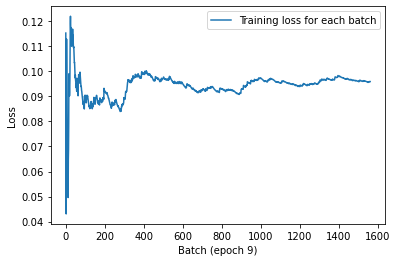

In [49]:
model = get_mnist_model()
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
model.fit(train_images, train_labels,
          epochs=10,
          callbacks=[LossHistory()],
          validation_data=(val_images, val_labels))

### Monitoring and visualization with TensorBoard

In [ ]:
model = get_mnist_model()
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

tensorboard = keras.callbacks.TensorBoard(
    log_dir="/full_path_to_your_log_dir",
)
model.fit(train_images, train_labels,
          epochs=10,
          validation_data=(val_images, val_labels),
          callbacks=[tensorboard])

In [ ]:
%load_ext tensorboard
%tensorboard --logdir /full_path_to_your_log_dir

## Writing your own training and evaluation loops

### Training versus inference

### Low-level usage of metrics

In [ ]:
metric = keras.metrics.SparseCategoricalAccuracy()
targets = [0, 1, 2]
predictions = [[1, 0, 0], [0, 1, 0], [0, 0, 1]]
metric.update_state(targets, predictions)
current_result = metric.result()
print(f"result: {current_result:.2f}")

In [ ]:
values = [0, 1, 2, 3, 4]
mean_tracker = keras.metrics.Mean()
for value in values:
    mean_tracker.update_state(value)
print(f"Mean of values: {mean_tracker.result():.2f}")

### A complete training and evaluation loop

**Writing a step-by-step training loop: the training step function**

In [ ]:
model = get_mnist_model()

loss_fn = keras.losses.SparseCategoricalCrossentropy()
optimizer = keras.optimizers.RMSprop()
metrics = [keras.metrics.SparseCategoricalAccuracy()]
loss_tracking_metric = keras.metrics.Mean()

def train_step(inputs, targets):
    with tf.GradientTape() as tape:
        predictions = model(inputs, training=True)
        loss = loss_fn(targets, predictions)
    gradients = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))

    logs = {}
    for metric in metrics:
        metric.update_state(targets, predictions)
        logs[metric.name] = metric.result()

    loss_tracking_metric.update_state(loss)
    logs["loss"] = loss_tracking_metric.result()
    return logs

**Writing a step-by-step training loop: resetting the metrics**

In [ ]:
def reset_metrics():
    for metric in metrics:
        metric.reset_state()
    loss_tracking_metric.reset_state()

**Writing a step-by-step training loop: the loop itself**

In [ ]:
training_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
training_dataset = training_dataset.batch(32)
epochs = 3
for epoch in range(epochs):
    reset_metrics()
    for inputs_batch, targets_batch in training_dataset:
        logs = train_step(inputs_batch, targets_batch)
    print(f"Results at the end of epoch {epoch}")
    for key, value in logs.items():
        print(f"...{key}: {value:.4f}")

**Writing a step-by-step evaluation loop**

In [ ]:
def test_step(inputs, targets):
    predictions = model(inputs, training=False)
    loss = loss_fn(targets, predictions)

    logs = {}
    for metric in metrics:
        metric.update_state(targets, predictions)
        logs["val_" + metric.name] = metric.result()

    loss_tracking_metric.update_state(loss)
    logs["val_loss"] = loss_tracking_metric.result()
    return logs

val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
val_dataset = val_dataset.batch(32)
reset_metrics()
for inputs_batch, targets_batch in val_dataset:
    logs = test_step(inputs_batch, targets_batch)
print("Evaluation results:")
for key, value in logs.items():
    print(f"...{key}: {value:.4f}")

### Make it fast with `tf.function`

**Adding a `tf.function` decorator to our evaluation step function**

In [ ]:
@tf.function
def test_step(inputs, targets):
    predictions = model(inputs, training=False)
    loss = loss_fn(targets, predictions)

    logs = {}
    for metric in metrics:
        metric.update_state(targets, predictions)
        logs["val_" + metric.name] = metric.result()

    loss_tracking_metric.update_state(loss)
    logs["val_loss"] = loss_tracking_metric.result()
    return logs

val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
val_dataset = val_dataset.batch(32)
reset_metrics()
for inputs_batch, targets_batch in val_dataset:
    logs = test_step(inputs_batch, targets_batch)
print("Evaluation results:")
for key, value in logs.items():
    print(f"...{key}: {value:.4f}")

### Leveraging `fit()` with a custom training loop

**Implementing a custom training step to use with `fit()`**

In [ ]:
loss_fn = keras.losses.SparseCategoricalCrossentropy()
loss_tracker = keras.metrics.Mean(name="loss")

class CustomModel(keras.Model):
    def train_step(self, data):
        inputs, targets = data
        with tf.GradientTape() as tape:
            predictions = self(inputs, training=True)
            loss = loss_fn(targets, predictions)
        gradients = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(gradients, model.trainable_weights))

        loss_tracker.update_state(loss)
        return {"loss": loss_tracker.result()}

    @property
    def metrics(self):
        return [loss_tracker]

In [ ]:
inputs = keras.Input(shape=(28 * 28,))
features = layers.Dense(512, activation="relu")(inputs)
features = layers.Dropout(0.5)(features)
outputs = layers.Dense(10, activation="softmax")(features)
model = CustomModel(inputs, outputs)

model.compile(optimizer=keras.optimizers.RMSprop())
model.fit(train_images, train_labels, epochs=3)

In [ ]:
class CustomModel(keras.Model):
    def train_step(self, data):
        inputs, targets = data
        with tf.GradientTape() as tape:
            predictions = self(inputs, training=True)
            loss = self.compiled_loss(targets, predictions)
        gradients = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(gradients, model.trainable_weights))
        self.compiled_metrics.update_state(targets, predictions)
        return {m.name: m.result() for m in self.metrics}

In [ ]:
inputs = keras.Input(shape=(28 * 28,))
features = layers.Dense(512, activation="relu")(inputs)
features = layers.Dropout(0.5)(features)
outputs = layers.Dense(10, activation="softmax")(features)
model = CustomModel(inputs, outputs)

model.compile(optimizer=keras.optimizers.RMSprop(),
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=[keras.metrics.SparseCategoricalAccuracy()])
model.fit(train_images, train_labels, epochs=3)

## Chapter summary